In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.utils import shuffle
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# Plot some images of the brain MRI scans

In [3]:
data_path = "../input/brain-mri-images-for-brain-tumor-detection"
#list of images with no tumors
Negative = os.listdir(data_path + '/no/')
#list of image with tumors
Positive = os.listdir(data_path + '/yes/')
print(f'There are {len(Negative)} MRI scans of brains with no tumor')
print(f'There are {len(Positive)} MRI scans of brains with tumor')
      

There are 98 MRI scans of brains with no tumor
There are 155 MRI scans of brains with tumor


In [ ]:
#plot some images of brain MRI with no tumor
fig = plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(data_path+'/no/'+ Negative[i])
    plt.imshow(img)
plt.suptitle("MRI images of brains with no tumor",fontsize=26)
plt.show()

In [ ]:
#plot some images of brain MRI with tumor
fig = plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(data_path+'/yes/'+ Positive[i])
    plt.imshow(img)
plt.suptitle("MRI images of brains with tumor",fontsize=26)
plt.show()

# Data processing 

For some reference on how to create a custom dataset:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

The custom dataset below is from

https://www.kaggle.com/code/tusharcode/brain-tumor-pytorch-model-cnn-and-autoencoders/notebook

with a minor modification (no autoencoder)


In [ ]:
from glob import glob
class BrainMRI(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
            array = array.reshape(1,self.height,self.width)         
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head(10))

In [18]:
df = BrainMRI(data_path)
df

                                               image  labels
0  ../input/brain-mri-images-for-brain-tumor-dete...       1
1  ../input/brain-mri-images-for-brain-tumor-dete...       1
2  ../input/brain-mri-images-for-brain-tumor-dete...       0
3  ../input/brain-mri-images-for-brain-tumor-dete...       0
4  ../input/brain-mri-images-for-brain-tumor-dete...       1
5  ../input/brain-mri-images-for-brain-tumor-dete...       1
6  ../input/brain-mri-images-for-brain-tumor-dete...       0
7  ../input/brain-mri-images-for-brain-tumor-dete...       1
8  ../input/brain-mri-images-for-brain-tumor-dete...       1
9  ../input/brain-mri-images-for-brain-tumor-dete...       0

# CNN model

This model is from 

https://www.kaggle.com/code/tusharcode/brain-tumor-pytorch-model-cnn-and-autoencoders/notebook

but instead of training for 200 epochs, I found that 20 epochs suffice to get good results. The trained model is saved as an output to this notebook. 

In [ ]:
class CNN_BrainMRI(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [17]:
model1 = CNN_BrainMRI()
model1.to(device)

CNN_BrainMRI(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

In [16]:
#count the number of parameters in the model
params = [p.numel() for p in model1.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    2304
     256
   32768
      32
    7936
     128
    8192
      64
  253952
       2
________
  305634


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

In [12]:
epochs = 20
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(df)//batch_size):
    
        data,target = df[n*batch_size:(n+1)*batch_size]

        ypred = model1.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss)
    if epoch%4 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

/tmp/ipykernel_33/2291858023.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]


Epochs: 0 Loss: 49.2958869934082
Epochs: 4 Loss: 0.6964111924171448
Epochs: 8 Loss: 0.5785360336303711
Epochs: 12 Loss: 0.27955329418182373
Epochs: 16 Loss: 0.1483566164970398


In [13]:
#save the trained model
torch.save(model1.state_dict(), 'CNN_BrainMRI_tumor_classification.pt')

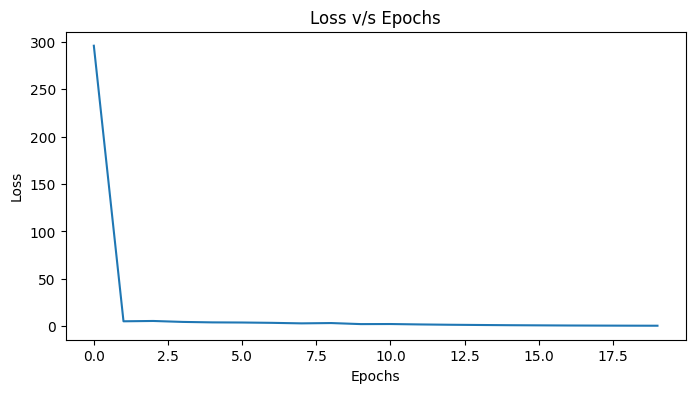

In [14]:
#get rid of the 'requires_grad' in the entries of loss_list
for i in range(len(loss_list)):
    loss_list[i] = loss_list[i].detach().numpy()
#plotting the loss per epoch
fig = plt.figure(figsize=(8,4))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss versus Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 'Evaluate' model

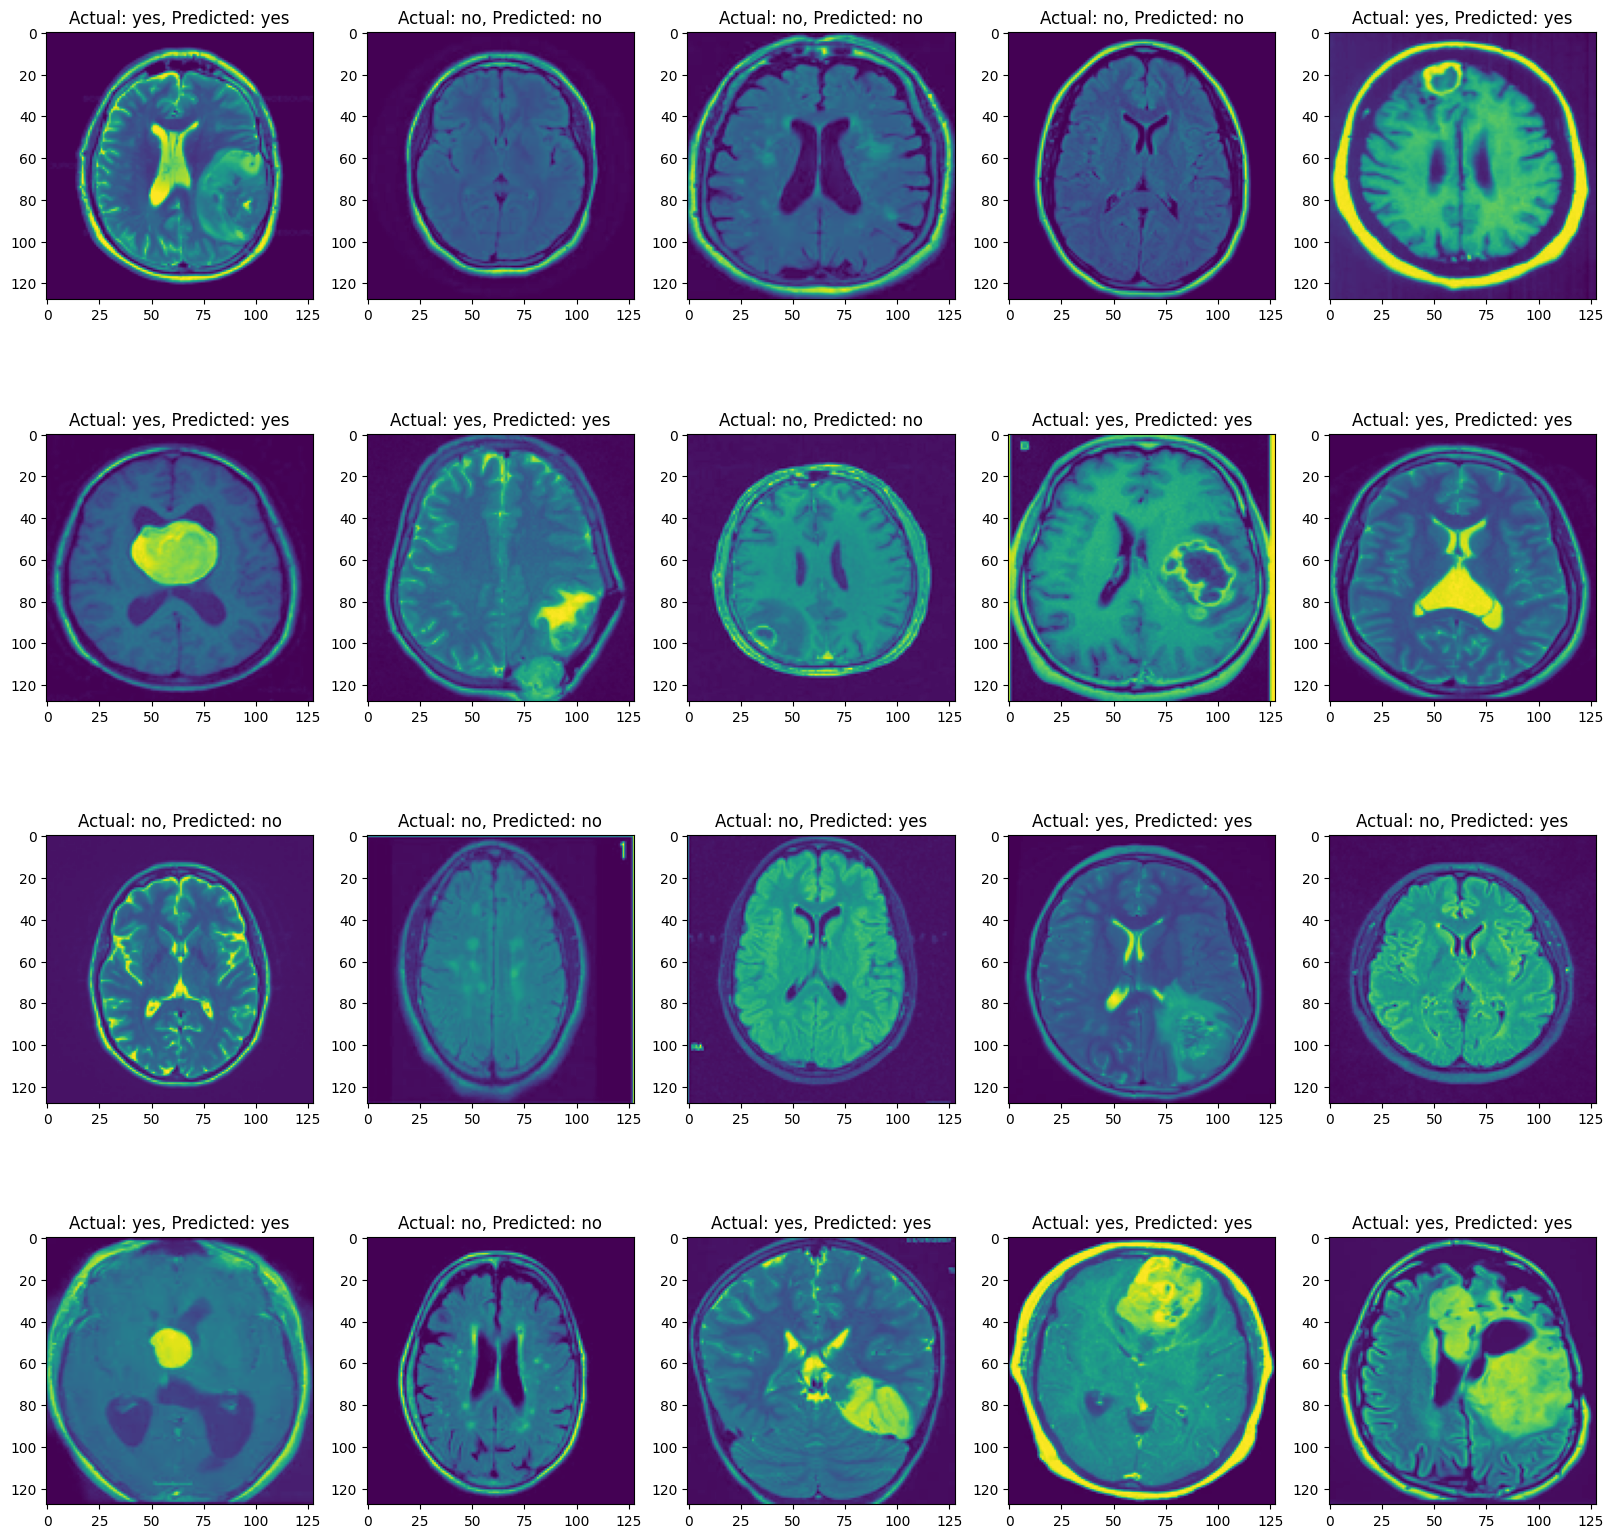

In [15]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = df[i]
    pred = model1.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]}, Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()